In [1]:
import numpy as np
import numpy.linalg as la
import scipy.linalg as scla
import scipy as sc
import math as math
import cmath as cm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab as P
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
def plotMatrix(Ai, normtype):
    #normtype 1 normalizes whole matrix
    #normtype 2 normalizes rows of matrix
    
    N, M = Ai.shape
  
    if(normtype == 1):
        norm = np.max(abs(Ai))
        A = Ai/(norm*2)
    elif(normtype == 2):
        A = Ai*1.
        for i in range(0, N, 1):
            norm = np.max(abs(Ai[i,]))
            A[i,] = Ai[i,]/(norm*2)
    
    t = np.arange(1, M+1, 1)
    for i in range(0, N, 1):
        base = A[i,]*0.
        base.fill(N-i)
        plt.fill_between(t, base, A[i,]+base)
    plt.ylim(0,N+1)
    plt.axis('off')

In [3]:
#% MATLAB code to compute seabed reflection coefficients RC given input model
#% m = [vp,vs,rho,ap,as] and grazing angles theta (in degrees), where
#% vp = p-wave velocity (m/s)
#% vs = s-wave velocity (m/s)
#% rho = density (kg/m^3)
#% ap = p-wave attenuation
#% as = s-wave attenuation

def getRC(m, theta):

    vw     = 1500.
    rhow   = 1030.
    vpc    = m[0]/complex(1, m[3]/(8.686*2.*np.pi))
    vsc    = m[1]/complex(1, m[4]/(8.686*2.*np.pi))
    theta1 = theta*np.pi/180.
    theta2 = cm.asin(vpc*cm.sin(theta1)/vw)
    phi    = cm.asin(vsc*cm.sin(theta1)/vw)
    n      = vpc/vw
    r      = m[2]/rhow
    m2     = vpc/vsc

    RC = abs(((((cm.cos(theta2)-n*r*cm.cos(theta1)*(1. - 2.*cm.sin(phi)*cm.sin(2*phi)*(cm.cos(phi)-(1./m2)*cm.cos(theta2))))
                /(cm.cos(theta2)+n*r*cm.cos(theta1)*(1.-2.*cm.sin(phi)*cm.sin(2*phi)*(cm.cos(phi)-(1./m2)*cm.cos(theta2))))))))

    return RC


#computes all the RC for a given model, given an array of angles.
def getlotRC(m, Oi):
    d = Oi*0.
    for i, oi in enumerate(Oi):
        d[i] = getRC(m, oi)
    return d

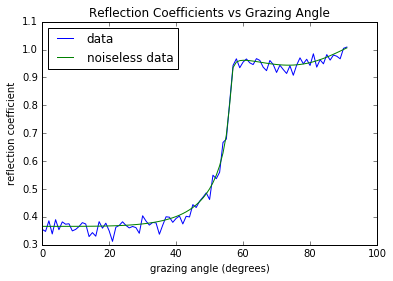

In [4]:
#Forward Problem
mt = [1800., 400., 1850., 0.2, 0.5,]

Oi = np.arange(0, 92, 1.)
RC = Oi*0.
d = RC*1.

for i, oi in enumerate(Oi):
    RC[i] = getRC(mt, oi)
    d[i] = RC[i] + np.random.normal(0, 0.02)
    
plt.plot(Oi, d, label='data')
plt.plot(Oi, RC, label='noiseless data')
plt.legend(loc=2)
plt.ylabel('reflection coefficient')
plt.xlabel('grazing angle (degrees)')
plt.title('Reflection Coefficients vs Grazing Angle')
#plt.savefig('a6extra.pdf')

In [20]:
bound = np.array([[1500., 2000.],
                   [0., 1000.],
                   [1200., 2200.],
                   [0., 1.],
                   [0., 1.]])

T = np.logspace(5, -1, 100)

In [34]:
print len(Elist)
print len(Elist2)

 5000
5001


In [37]:
#import inversionLib as iL
reload(iL)
mlist2, Elist2 = iL.simulated_annealing(objective, mo, bound, T, 10)
print mlist[-1]

SA -I||||||||||||||||||||||||||||||||||||||||||||||||||I- [  1.80166988e+03   4.17452443e+02   1.82919466e+03   2.27029346e-01
   4.25074126e-01]


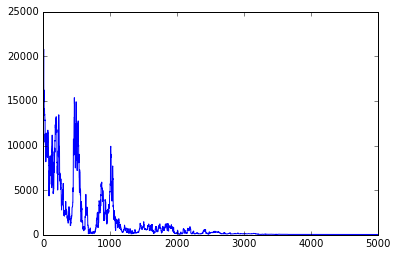

In [38]:
plt.plot(Elist2)

In [36]:
def objective(m):
    damp = d - getlotRC(m, Oi)
    En = np.dot(damp.T, damp)/(2.*0.02**2)
    return En

SA -I||||||||||||||||||||||||||||||||||||||||||||||||| I- time1: 13.8824839592
SA -I||||||||||||||||||||||||||||||||||||||||||||||||||I- time2: 13.8143999577
[  1.80171087e+03   4.11397994e+02   1.81847011e+03   1.95399690e-01
   6.68253232e-01]
[1800.0, 400.0, 1850.0, 0.2, 0.5]


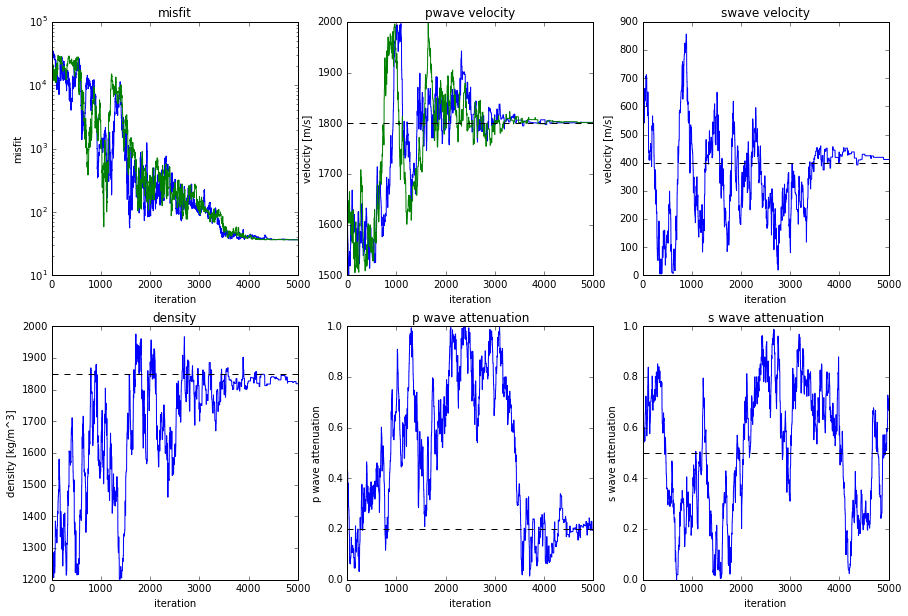

In [41]:
import time as timer

mo = np.array([1600., 500., 1300., 0.5, 0.5])
sig = 0.02
npar = len(mo)
b = 10
Elist = np.zeros(len(T)*b*npar)
dam = d - getlotRC(mo, Oi)
Ep = np.dot(dam.T, dam)/(2.*sig**2)
m = mo*1.
mlist = np.zeros((len(T)*b*npar, npar))

t1 = timer.time()
ind = 0
for j, tt in enumerate(T):
    for h in range(0, b):
        # Go through and perturb each parameter at the given T.
        for k in range(0, npar):
            dm = np.random.normal(0., abs(bound[k][1]-bound[k][0])/20.)
            count = 1
            
            mnew = m*1.
            mnew[k] = m[k] + dm
            
            #check to make sure perturbation is within bounds. rejects MH criteria.
            if( (mnew[k] > bound[k][1]) or (mnew[k] < bound[k][0])):
                Elist[ind] = Ep*1.
                mlist[ind] = m*1.
            else:
                #get energy for perturbed model.
                damp = d - getlotRC(mnew, Oi)
                En = np.dot(damp.T, damp)/(2.*sig**2)
                deltaE = En-Ep
                #if new energy is lower accept perturbation.
                if(deltaE <= 0): 
                    Elist[ind] = En*1.
                    Ep = En*1.
                    mlist[ind] = mnew*1.
                    m = mnew*1.
                    
                #challenge new perturbed model with a random number.
                else:
                    
                    Godzilla = np.random.uniform(0., 1.)
                    MonsterZero = np.exp(-1.*deltaE/tt)
                    
                    if(Godzilla <= MonsterZero):
                        Elist[ind] = En*1.
                        Ep = En*1.
                        mlist[ind] = mnew*1.
                        m = mnew*1.
                    else:
                        Elist[ind] = Ep*1.
                        mlist[ind] = m*1.
            ind = ind + 1
    print '\rSA -I{0}{1}I-'.format('|'*(j*50/len(T)), ' '*(50 - j*50/len(T))),
print 'time1: {0}'.format(timer.time() -t1)

t2 = timer.time()
mlist2, Elist2 = iL.simulated_annealing(objective, mo, bound, T, 10)
print 'time2: {0}'.format(timer.time() -t2)
mlist2 = np.array(mlist2)

it = np.arange(0, len(Elist), 1)
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.semilogy(it, Elist)
plt.semilogy(it, np.array(Elist2[1:]))
plt.title('misfit')
plt.xlabel('iteration')
plt.ylabel('misfit')

plt.subplot(2,3,2)
plt.plot(it, mlist[:,0])
plt.plot(it, mlist2[1:,0])
plt.plot([np.min(it), np.max(it)], [1800, 1800], 'k--')
plt.title('pwave velocity')
plt.xlabel('iteration')
plt.ylabel('velocity [m/s]')


plt.subplot(2,3,3)
plt.plot(it, mlist[:,1])
plt.plot([np.min(it), np.max(it)], [400, 400], 'k--')
plt.title('swave velocity')
plt.xlabel('iteration')
plt.ylabel('velocity [m/s]')

plt.subplot(2,3,4)
plt.plot(it, mlist[:,2])
plt.plot([np.min(it), np.max(it)], [1850, 1850], 'k--')
plt.title('density')
plt.xlabel('iteration')
plt.ylabel('density [kg/m^3]')

plt.subplot(2,3,5)
plt.plot(it, mlist[:,3])
plt.plot([np.min(it), np.max(it)], [0.2, 0.2], 'k--')
plt.xlabel('iteration')
plt.ylabel('p wave attenuation')
plt.title('p wave attenuation')

plt.subplot(2,3,6)
plt.plot(it, mlist[:,4])
plt.plot([np.min(it), np.max(it)], [0.5, 0.5], 'k--')
plt.xlabel('iteration')
plt.ylabel('s wave attenuation')
plt.title('s wave attenuation')

#plt.savefig('a6q1b.pdf')

# true model is mt = [1800., 400., 1850., 0.2, 0.5,]
print m
print mt

In [38]:
T = np.ones(800)
mo = np.array([1.79766812e+03, 3.87284041e+02, 1.85319124e+03, 1.87713453e-01, 9.60786519e-01])
sig = 0.02
npar = len(mo)
b = 10
Elist = np.zeros(len(T)*b*npar)
dam = d - getlotRC(mo, Oi)
Ep = np.dot(dam.T, dam)/(2.*sig**2)
m = mo*1.
mlist = np.zeros((len(T)*b*npar, npar))

ind = 0

for j, tt in enumerate(T):
    if(j%100 == 0): print str((100*j)/len(T))+"%"
    for h in range(0, b):
        # Go through and perturb each parameter at the given T.
        for k in range(0, npar):
            dm = np.random.normal(0., abs(bound[k][1]-bound[k][0])/20.)
            count = 1
            
            mnew = m*1.
            mnew[k] = m[k] + dm
            
            #check to make sure perturbation is within bounds. rejects MH criteria.
            while((mnew[k] > bound[k][1]) or (mnew[k] < bound[k][0])):
                dm = np.random.normal(0., abs(bound[k][1]-bound[k][0])/20.)
                mnew = m*1.
                mnew[k] = m[k] + dm
            
            if( (mnew[k] > bound[k][1]) or (mnew[k] < bound[k][0])):
                Elist[ind] = Ep*1.
                mlist[ind] = m*1.
            else:
                #get energy for perturbed model.
                damp = d - getlotRC(mnew, Oi)
                En = np.dot(damp.T, damp)/(2.*sig**2)
                deltaE = En-Ep
                #if new energy is lower accept perturbation.
                if(deltaE <= 0): 
                    Elist[ind] = En*1.
                    Ep = En*1.
                    mlist[ind] = mnew*1.
                    m = mnew*1.
                    
                #challenge new perturbed model with a random number.
                else:
                    
                    Godzilla = np.random.uniform(0., 1.)
                    MonsterZero = np.exp(-1.*deltaE/tt)
                    
                    if(Godzilla <= MonsterZero):
                        Elist[ind] = En*1.
                        Ep = En*1.
                        mlist[ind] = mnew*1.
                        m = mnew*1.
                    else:
                        Elist[ind] = Ep*1.
                        mlist[ind] = m*1.
            ind = ind + 1

print '100% done.'

0%
25%
50%
75%
100% done.


787.423981108
282.579435771
787.103258944
0.297617825992
0.310852243551


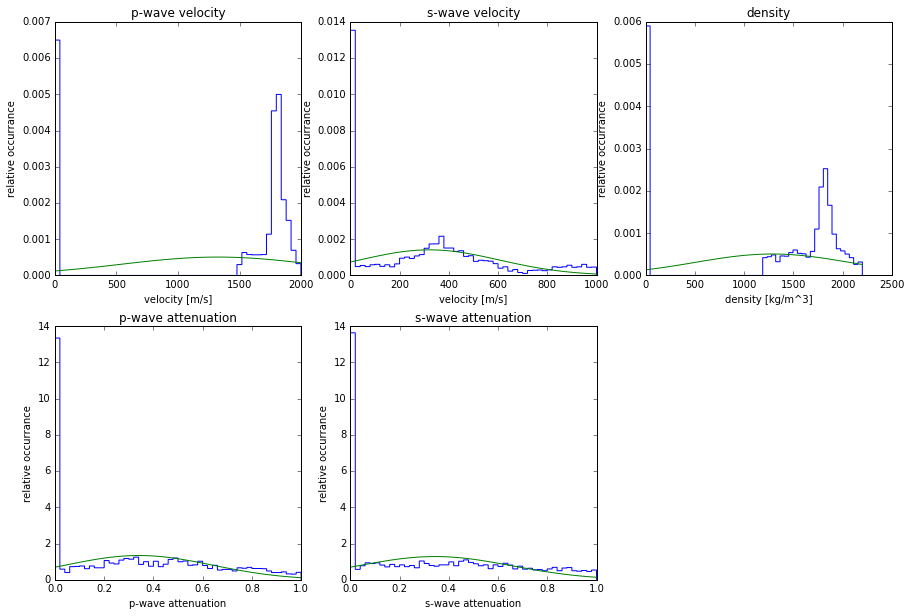

In [8]:
numbins = 50

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.hist(mlist[:,0], numbins, normed=True, histtype='step')
ps = np.std(mlist[:,0])
pm = np.mean(mlist[:,0])
x = np.linspace(np.min(mlist[:,0]), np.max(mlist[:,0]), 100)
gp = (1./(ps*np.sqrt(2.*np.pi)))*np.exp((-0.5)*((x - pm)/ps)**2)
plt.plot(x, gp)
print ps

plt.title('p-wave velocity')
plt.ylabel('relative occurrance')
plt.xlabel('velocity [m/s]')

plt.subplot(2,3,2)
plt.hist(mlist[:,1], numbins, normed=True, histtype='step')
plt.title('s-wave velocity')
plt.ylabel('relative occurrance')
plt.xlabel('velocity [m/s]')

ps = np.std(mlist[:,1])
pm = np.mean(mlist[:,1])
x = np.linspace(np.min(mlist[:,1]), np.max(mlist[:,1]), 100)
gp = (1./(ps*np.sqrt(2.*np.pi)))*np.exp((-0.5)*((x - pm)/ps)**2)
plt.plot(x, gp)
print ps

plt.subplot(2,3,3)
plt.hist(mlist[:,2], numbins, normed=True, histtype='step')
plt.title('density')
plt.ylabel('relative occurrance')
plt.xlabel('density [kg/m^3]')
ps = np.std(mlist[:,2])
pm = np.mean(mlist[:,2])
x = np.linspace(np.min(mlist[:,2]), np.max(mlist[:,2]), 100)
gp = (1./(ps*np.sqrt(2.*np.pi)))*np.exp((-0.5)*((x - pm)/ps)**2)
plt.plot(x, gp)
print ps

plt.subplot(2,3,4)
plt.hist(mlist[:,3], numbins, normed=True, histtype='step')
plt.title('p-wave attenuation')
plt.ylabel('relative occurrance')
plt.xlabel('p-wave attenuation')
ps = np.std(mlist[:,3])
pm = np.mean(mlist[:,3])
x = np.linspace(np.min(mlist[:,3]), np.max(mlist[:,3]), 100)
gp = (1./(ps*np.sqrt(2.*np.pi)))*np.exp((-0.5)*((x - pm)/ps)**2)
plt.plot(x, gp)
print ps


plt.subplot(2,3,5)
plt.hist(mlist[:,4], numbins, normed=True, histtype='step')
plt.title('s-wave attenuation')
plt.ylabel('relative occurrance')
plt.xlabel('s-wave attenuation')
ps = np.std(mlist[:,4])
pm = np.mean(mlist[:,4])
x = np.linspace(np.min(mlist[:,4]), np.max(mlist[:,4]), 100)
gp = (1./(ps*np.sqrt(2.*np.pi)))*np.exp((-0.5)*((x - pm)/ps)**2)
plt.plot(x, gp)
print ps


#plt.savefig('a6q1c.pdf')